In [1]:
import argparse

import botorch
import gpytorch
import torch

from utils import *
import traceback
import matplotlib.pyplot as plt
from gpytorch.kernels import RBFKernel
# from torch.distributions import MultivariateNormal
import os
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
from gpytorch.distributions import MultivariateNormal

default_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


/home/yl9959/mtpfn/PFNs/pfns/priors/utils.py:293: FutureWarning: Decorating classes is deprecated and will be disabled in future versions. You should only decorate functions or methods. To preserve the current behavior of class decoration, you can directly decorate the `__init__` method and nothing else.
  @torch.no_grad()


In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:


def get_test_function(n_samples, lengthscale=None, seed=0):
    with botorch.manual_seed(seed):        
        train_x = torch.rand(n_samples, 1)
        test_x = torch.linspace(0, 1, 1000).view(-1, 1)
        all_x = torch.cat([train_x, test_x], dim=0)
        
        rbf = gpytorch.kernels.RBFKernel()
        if lengthscale:
            rbf.lengthscale = lengthscale
        else:
            rbf.lengthscale = torch.distributions.Gamma(3, 6).sample()
        
        
        mean = torch.zeros(all_x.size(0))
        covar = rbf(all_x)
        
        y = MultivariateNormal(mean, covar).sample().unsqueeze(1)
        train_y = y[:n_samples]
        test_y = y[n_samples:]
        
    return train_x, train_y, test_x, test_y


In [64]:

def plot(test_info, pfn_infos):
    n_plots = len(pfn_infos) + 1
    fig, axs = plt.subplots(1, n_plots, figsize=(n_plots * 5, 4))
    
    queried = []
    for i, pfn_info in enumerate(pfn_infos):        
        pfn_id, model, model_dim = pfn_info
        train_x, train_y, test_x, test_y = test_info
        train_task_id = torch.zeros(train_x.size(0))
        
        if model_dim > 1:
            # pad train and test with 0s
            padded_train_x = torch.cat([train_x, torch.zeros(train_x.size(0), model_dim - 1)], dim=1)
            padded_test_x = torch.cat([test_x, torch.zeros(test_x.size(0), model_dim - 1)], dim=1)
        else:
            padded_train_x = train_x
            padded_test_x = test_x
            
        # train_x, train_task_id, train_y, test_x, 
        posterior = pfn_predict(model, train_task_id.to(default_device), padded_train_x.to(default_device), train_y.to(default_device), padded_test_x.to(default_device))
        mean = posterior.mean.cpu()
        # std = posterior.variance.sqrt().cpu()
        lower, upper = posterior.lower.cpu(), posterior.upper.cpu()
        
        args = train_task_id, padded_train_x, train_y, None, padded_test_x, test_y
        args = [arg.to(default_device) if arg is not None else None for arg in args]
        next_x, next_y = pfn_get_best(model, *args)
        next_x, next_y = next_x[0].cpu().item(), next_y.cpu().item()
        queried.append((next_x, next_y))
        
        ax = axs[i]
        ax.plot(test_x, test_y, label="true", color="C0")
        ax.scatter(train_x, train_y, label="train", color="C0")
        ax.plot(test_x, mean, label="mean", color="C1")
        ax.fill_between(test_x.flatten(), lower.flatten(), upper.flatten(), alpha=0.2, color="C1")
        ax.set_title(f"PFN {pfn_id}")
        ax.axvline(next_x, color="C3", linestyle="--", label="query")
        
        

    gp = SingleTaskGP(train_x, train_y)
    mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
    fit_gpytorch_mll(mll)
    gp.eval()
    gp_pred = gp.posterior(test_x)
    gp_mean = gp_pred.mean.cpu().detach()
    gp_std = gp_pred.variance.sqrt().cpu().detach()
    
    args = train_task_id, train_x, train_y, torch.zeros_like(test_y), test_x.unsqueeze(1), test_y.unsqueeze(1)
    next_x, next_y = gp_get_best(*args)
    next_x, next_y = next_x.cpu().item(), next_y.cpu().item()
    queried.append((next_x, next_y))
    
    ax = axs[-1]
    ax.plot(test_x, test_y, label="true", color="C0")
    ax.scatter(train_x, train_y, label="train", color="C0")
    ax.plot(test_x, gp_mean, label="gp mean", color="C2")
    ax.fill_between(test_x.flatten(), gp_mean.flatten() - 2 * gp_std.flatten(), gp_mean.flatten() + 2 * gp_std.flatten(), alpha=0.2, color="C2")
    ax.legend()
    ax.set_title("GP")
    ax.axvline(next_x, color="C3", linestyle="--", label="query")
    
    ax_min_y = min([ax.get_ylim()[0] for ax in axs])
    ax_max_y = max([ax.get_ylim()[1] for ax in axs])
    for ax in axs:
        ax.set_ylim(ax_min_y, ax_max_y)
    
    plt.show()
    
    return queried
    # return fig, axs


In [53]:
model_names = ["fresh-snowball-475", "young-grass-475", "fluent-durian-477", "wild-serenity-478"]
models = [load_model(f"/home/yl9959/mtpfn/wandb_links/{name}", best=True).to(default_device) for name in model_names]

pfn_infos = [
    ("bar 0.2", models[0], 1),
    ("gauss 0.2", models[1], 1),
    ("bar", models[2], 1),
    ("gauss", models[3], 1),
]

Using 2000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using a Transformer with 18.38 M parameters
Loaded model
Using a Transformer with 17.35 M parameters
Loaded model
Using 2000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using a Transformer with 18.38 M parameters
Loaded model
Using a Transformer with 17.35 M parameters
Loaded model


In [54]:
model_names = [
    "sparkling-microwave-480", 
    "wobbly-donkey-484", 
    "likely-donkey-479", 
    "fallen-cherry-483",
    "stilted-night-482",
    "youthful-wildflower-481",
]
models = [load_model(f"/home/yl9959/mtpfn/wandb_links/{name}", best=True).to(default_device) for name in model_names]

pfn_infos = [
    ("G 0.", models[0], 3),
    ("G 0.1", models[1], 3),
    ("G 0.2", models[2], 3),
    ("B 0.", models[3], 3),
    ("B 0.1", models[4], 3),
    ("B 0.2", models[5], 3),
]

Using a Transformer with 25.77 M parameters
Loaded model
Using a Transformer with 25.77 M parameters
Loaded model
Using a Transformer with 25.77 M parameters
Loaded model
Using 2000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using a Transformer with 26.79 M parameters
Loaded model
Using 2000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using a Transformer with 26.79 M parameters
Loaded model
Using 2000 y evals to estimate 1000 buckets. Cut off the last 0 ys.
Using a Transformer with 26.79 M parameters
Loaded model


Seed 0
G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


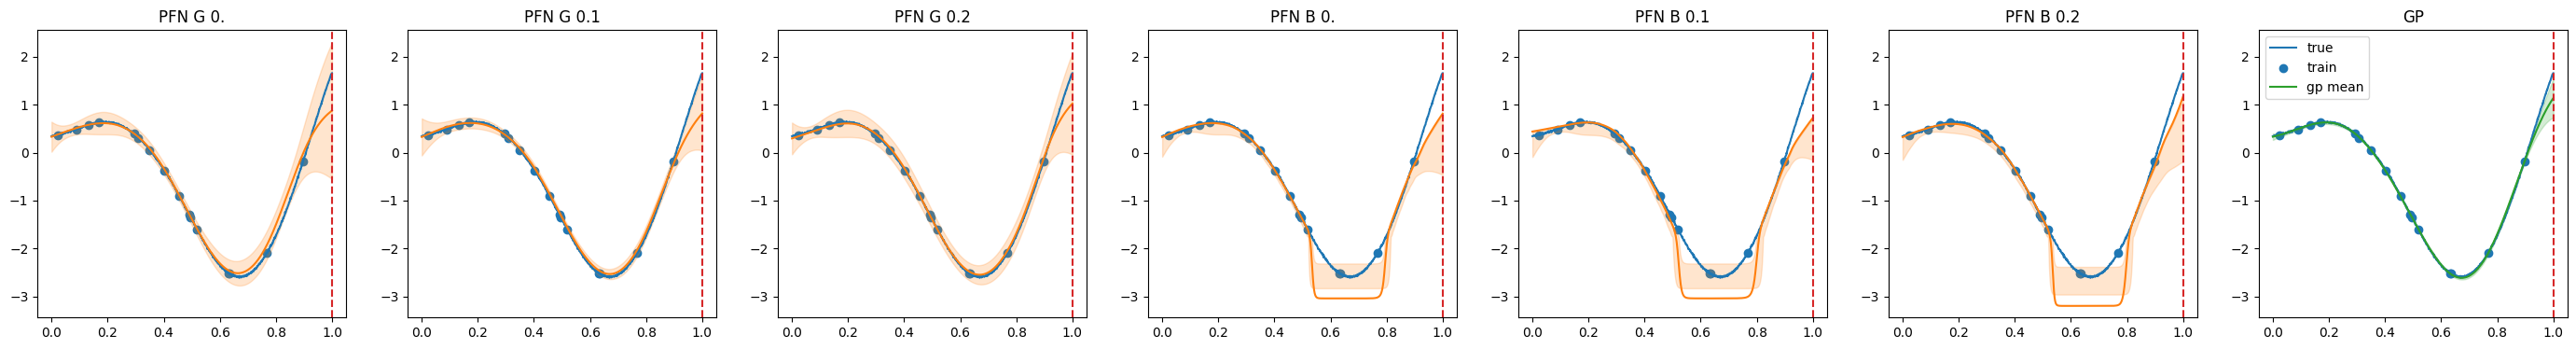

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


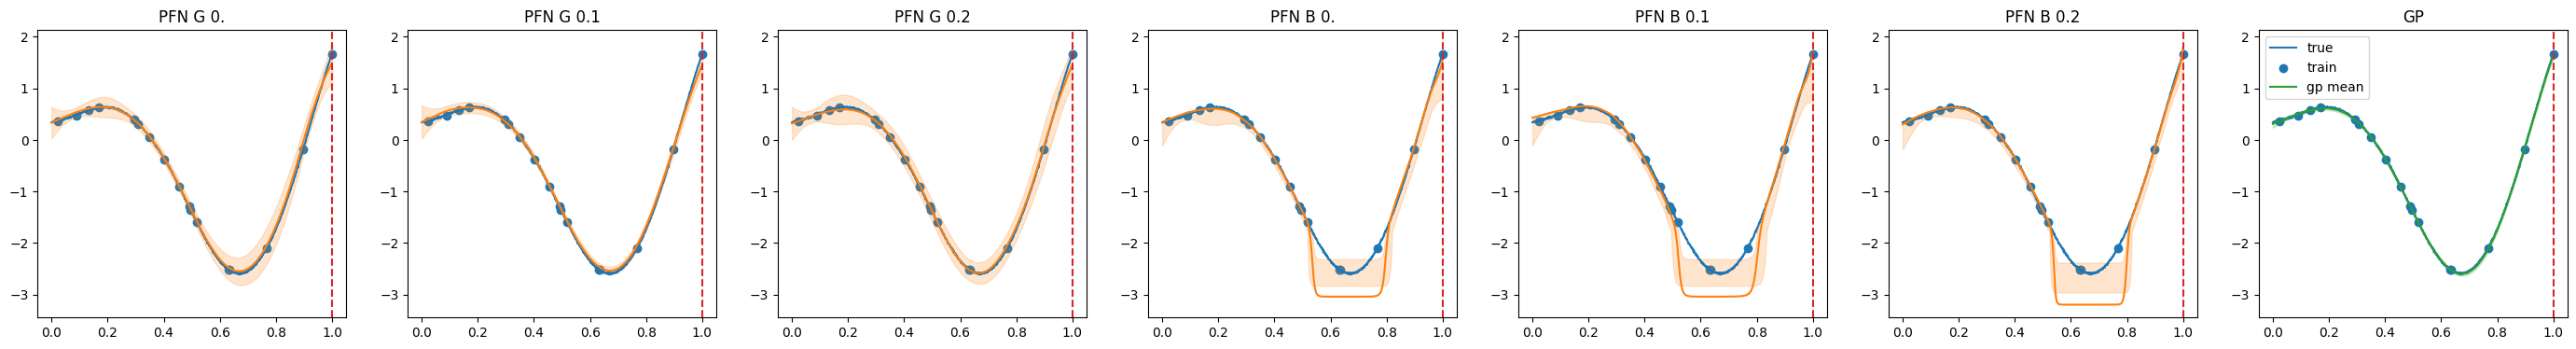

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


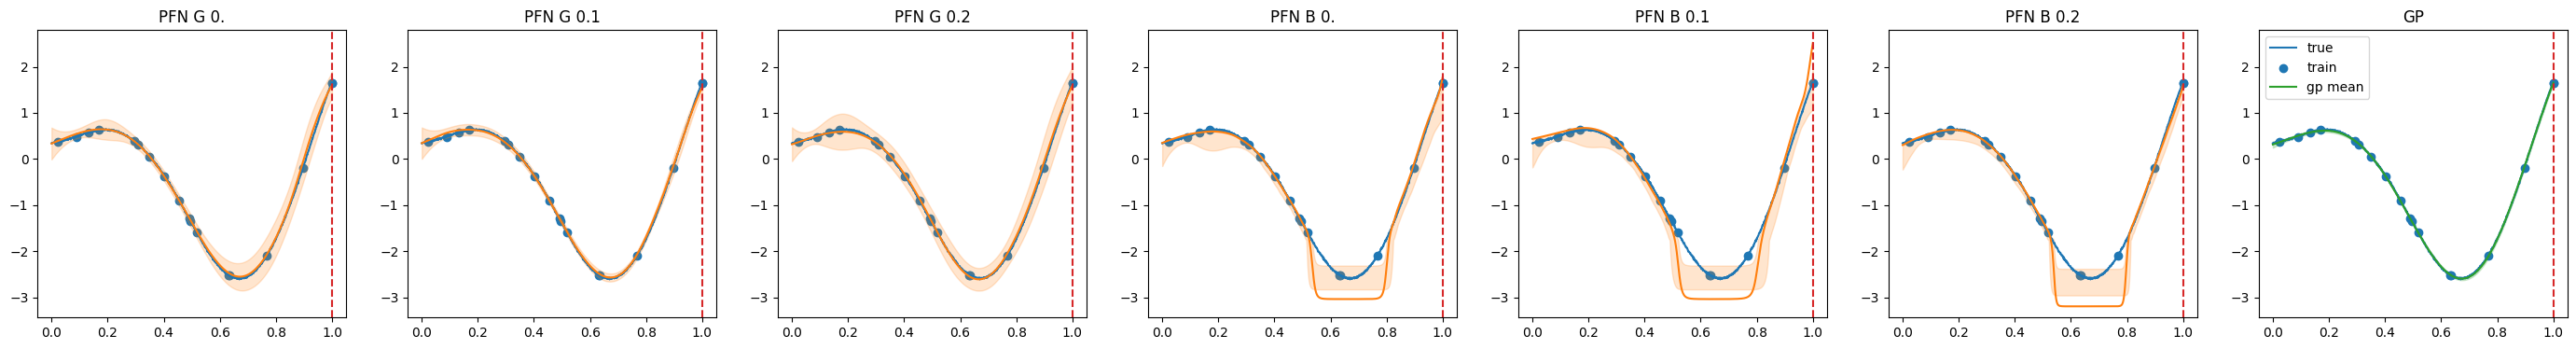

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


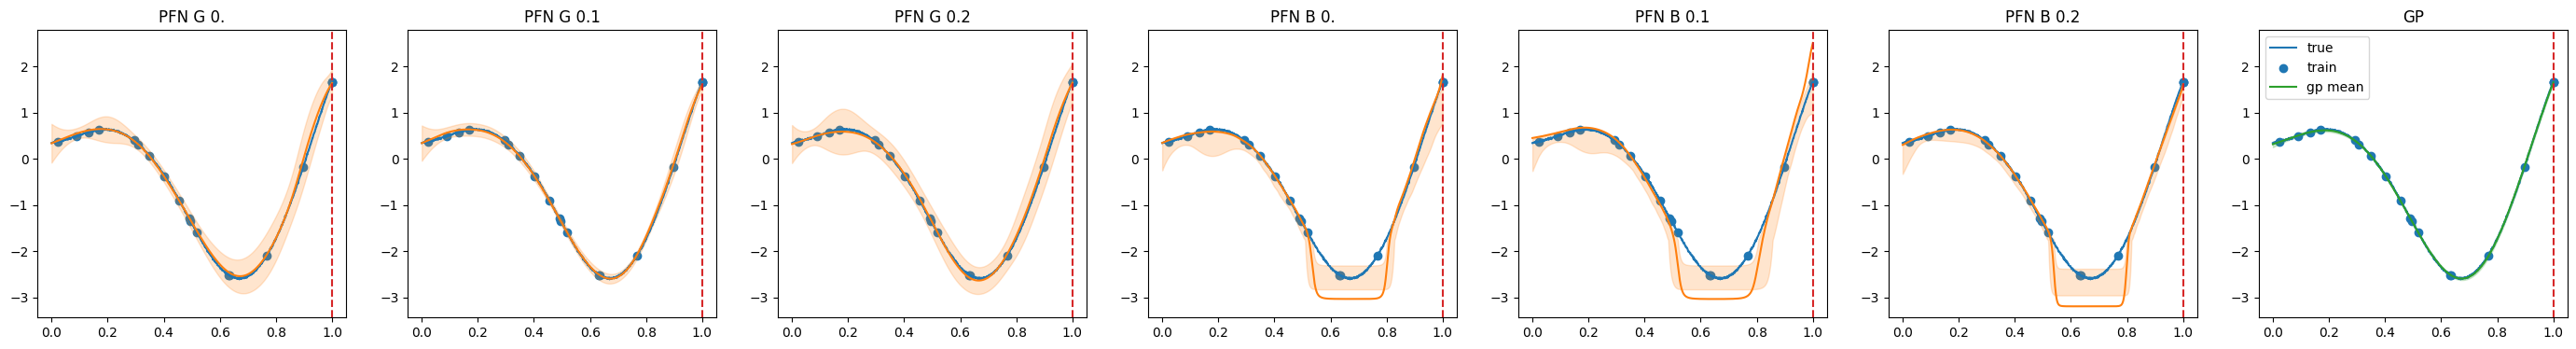

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


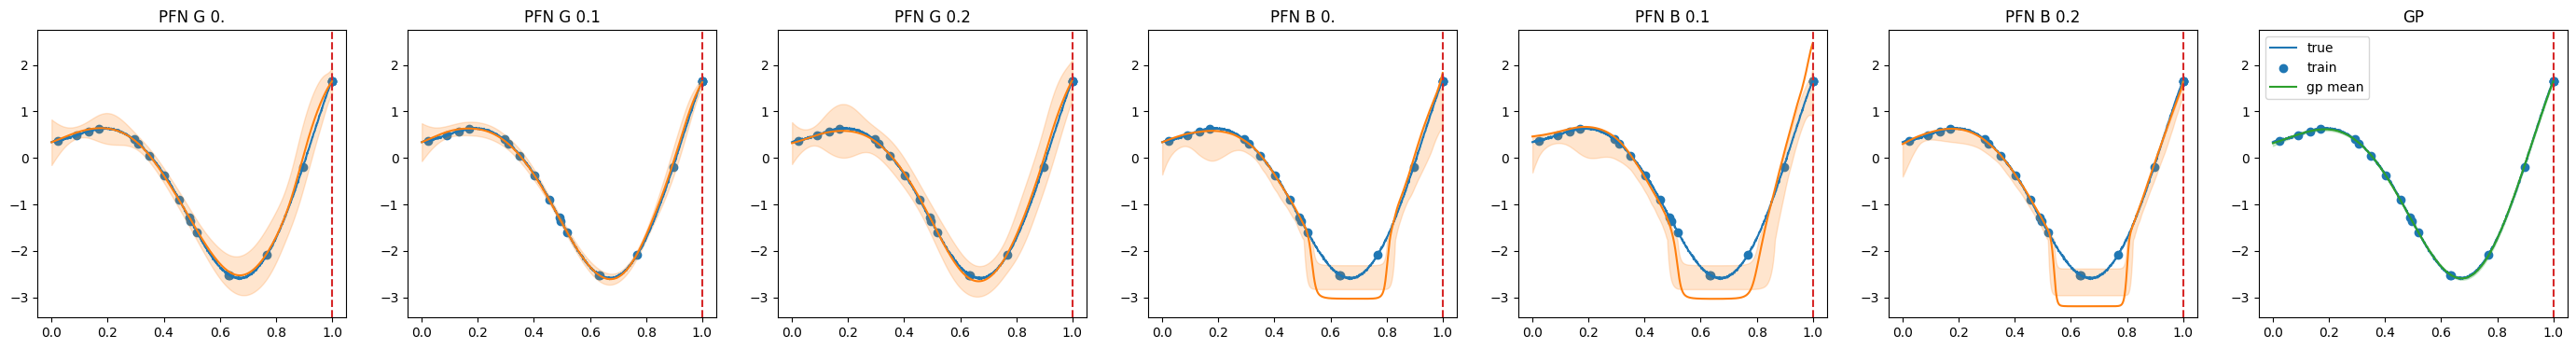

Seed 1
G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


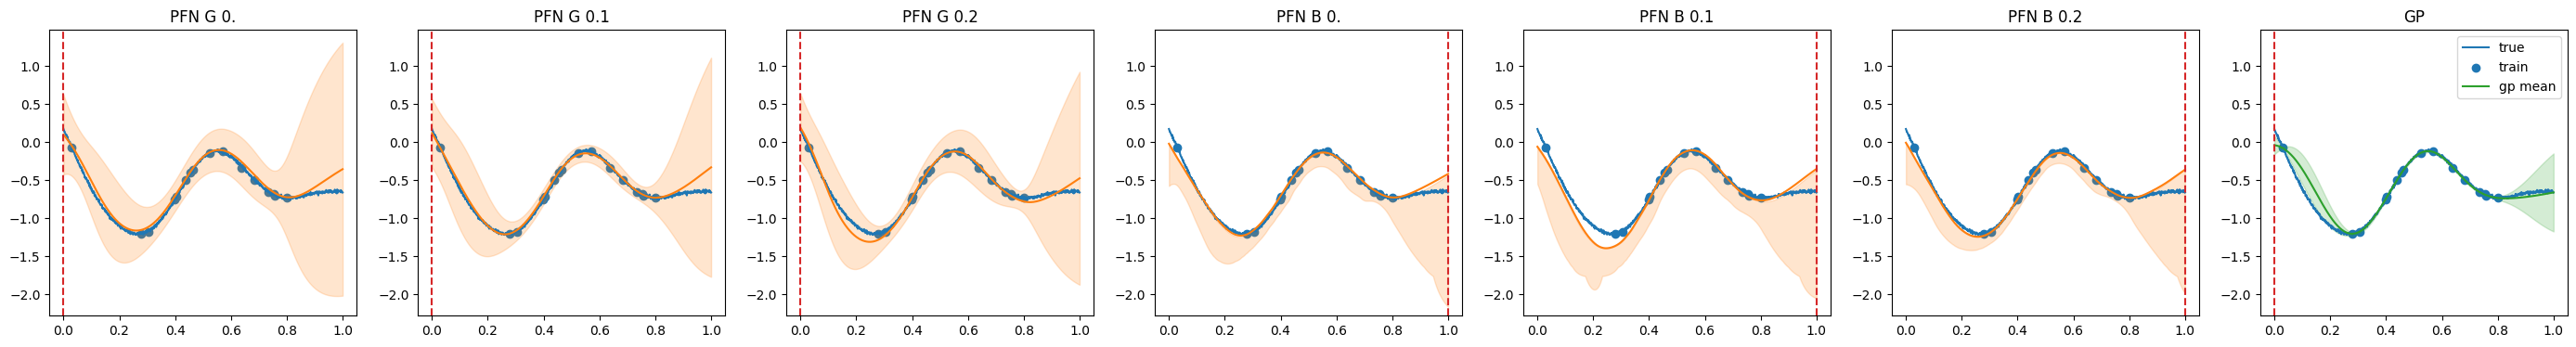

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


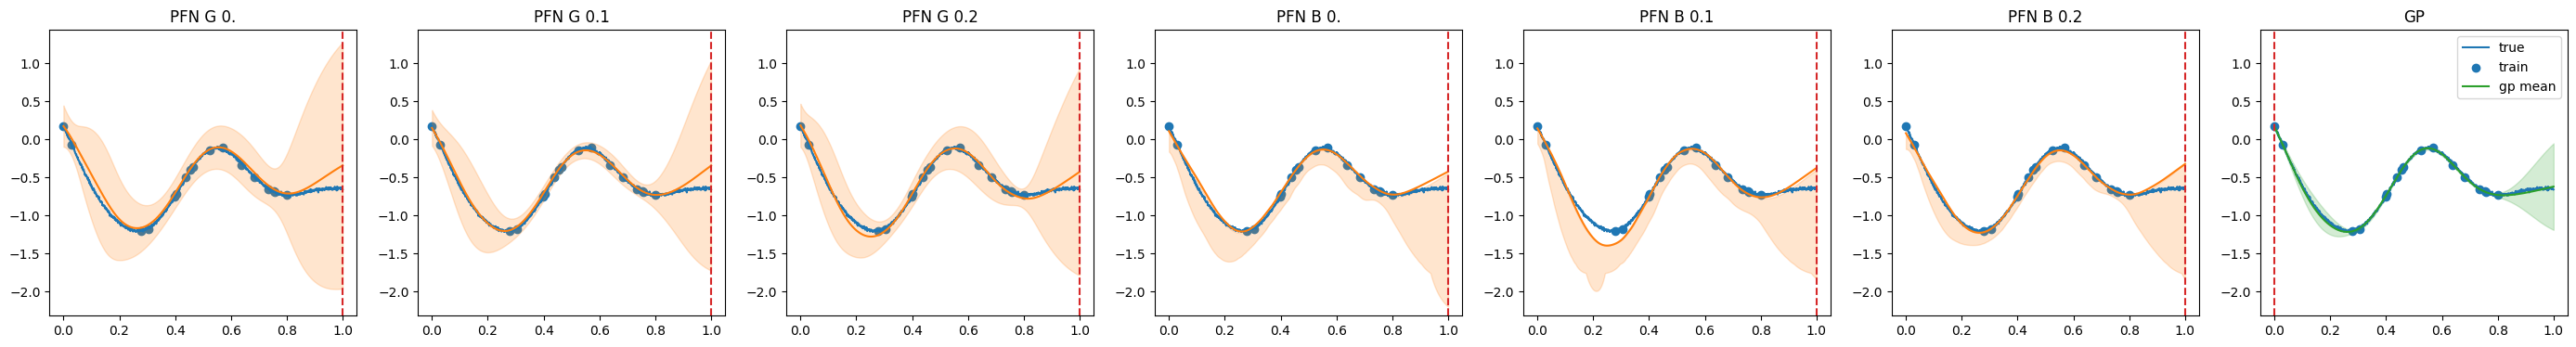

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


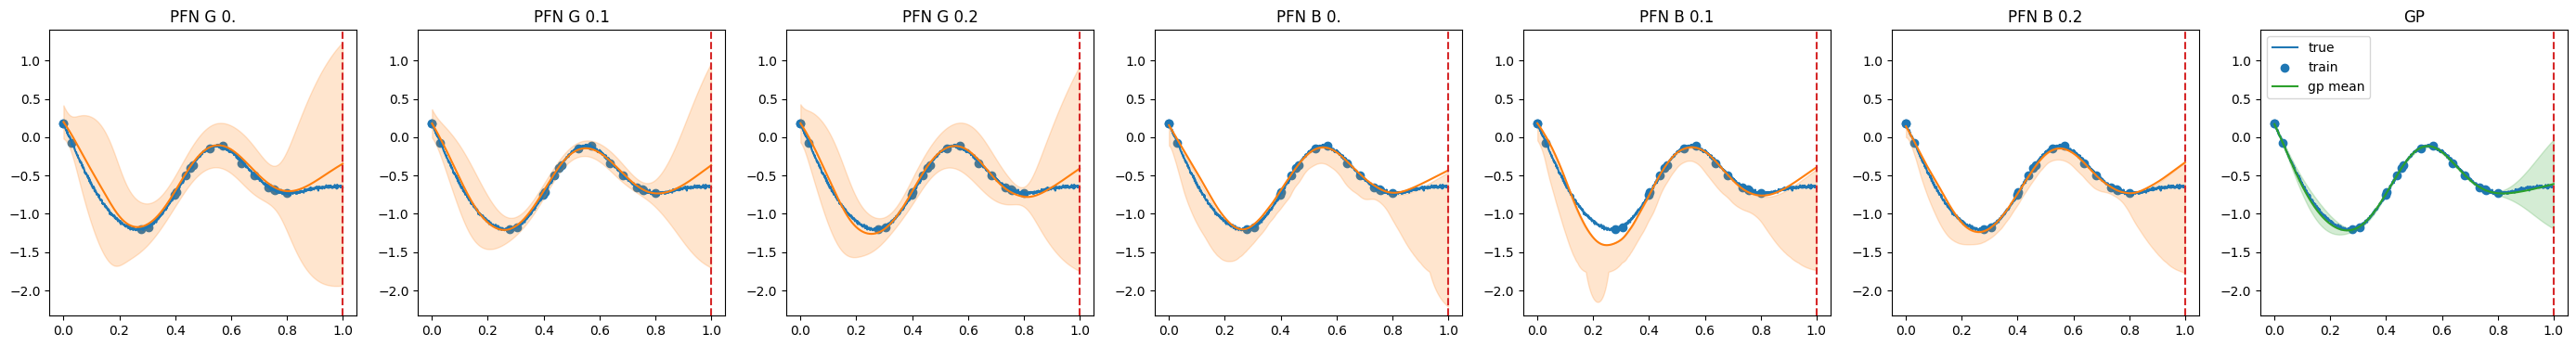

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


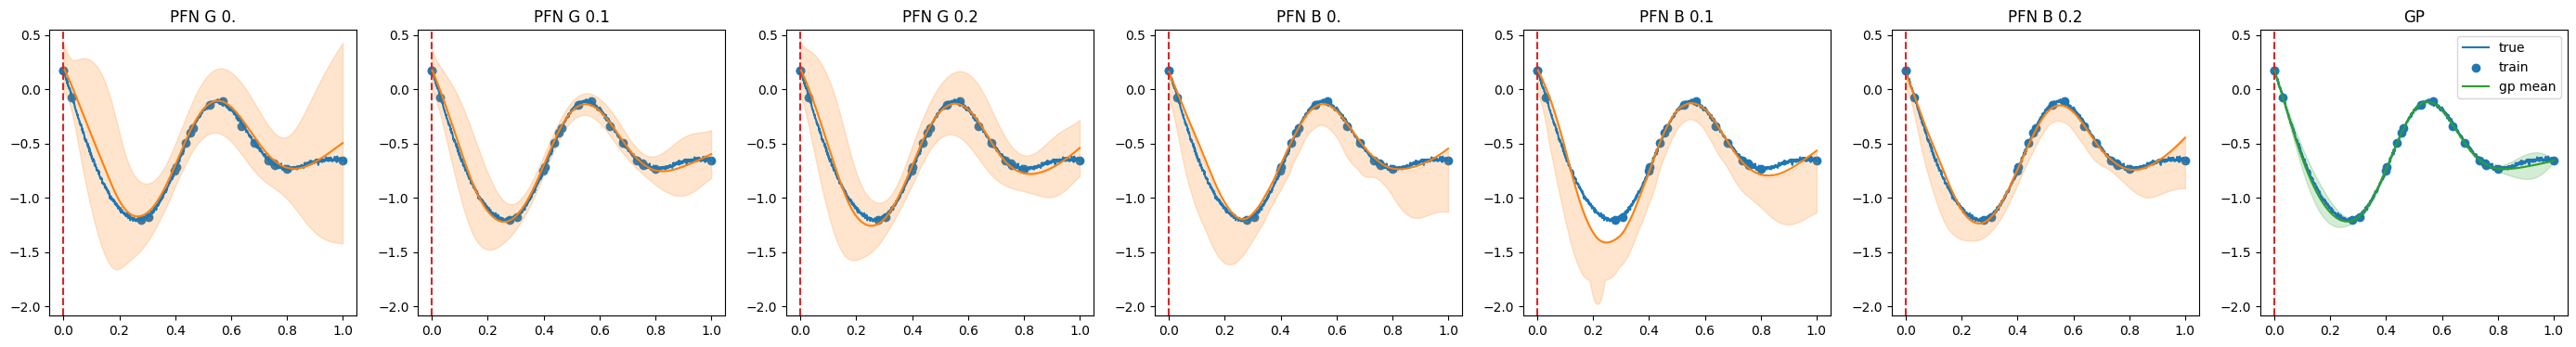

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


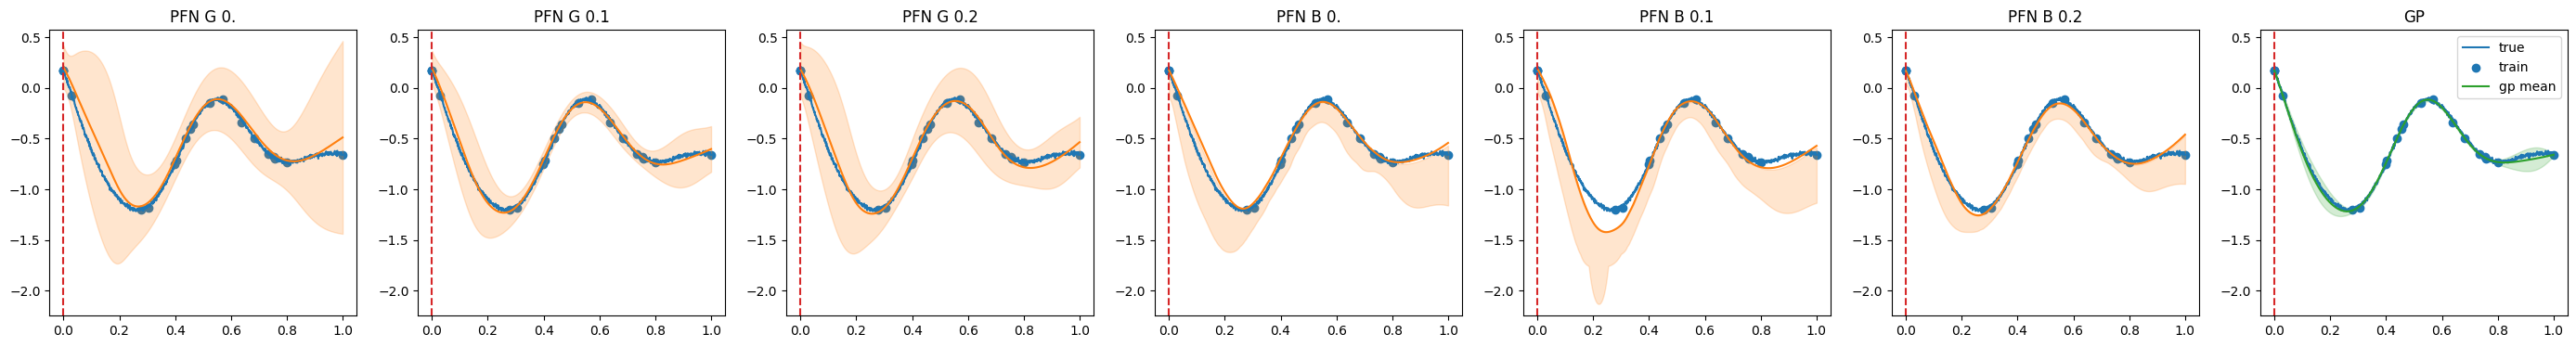

Seed 2
G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


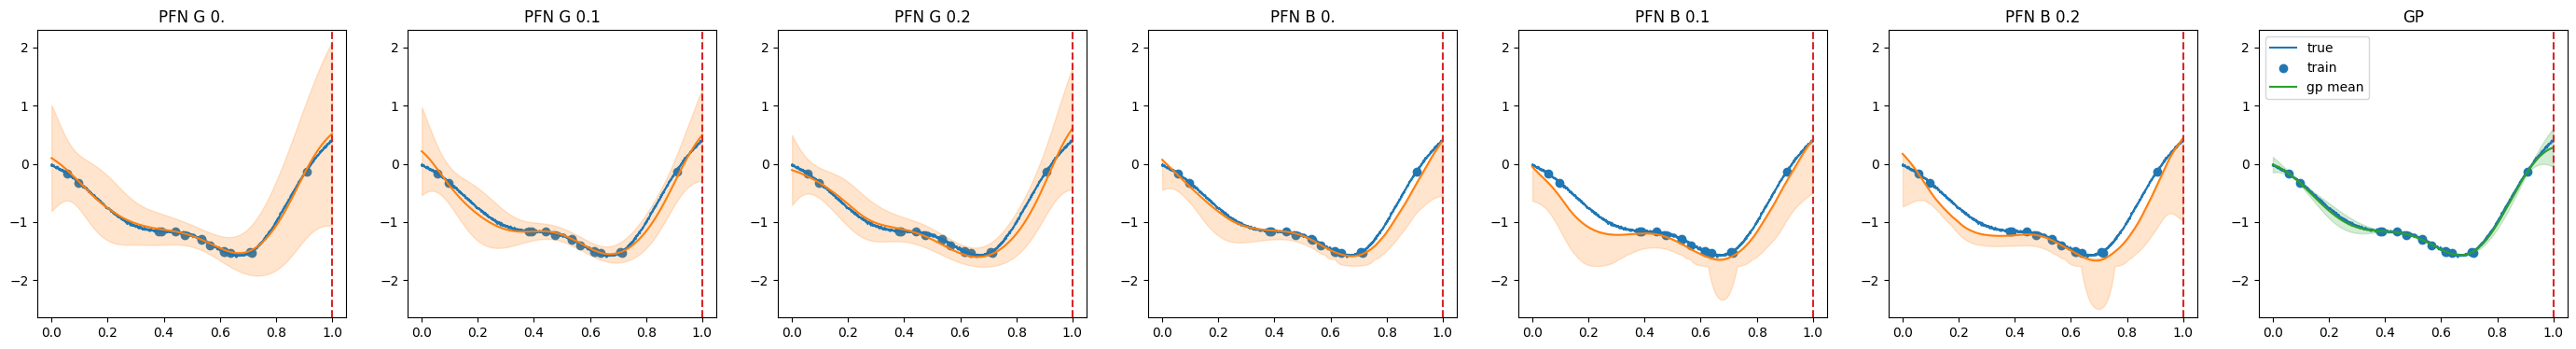

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


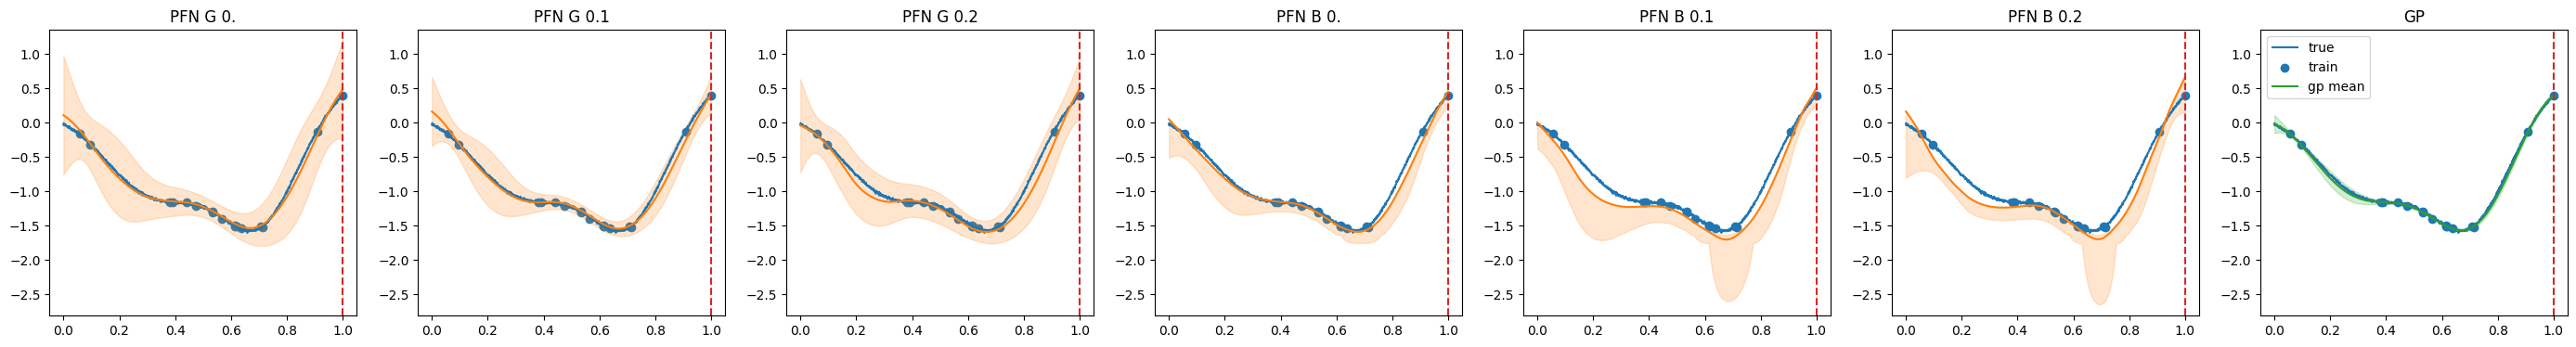

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


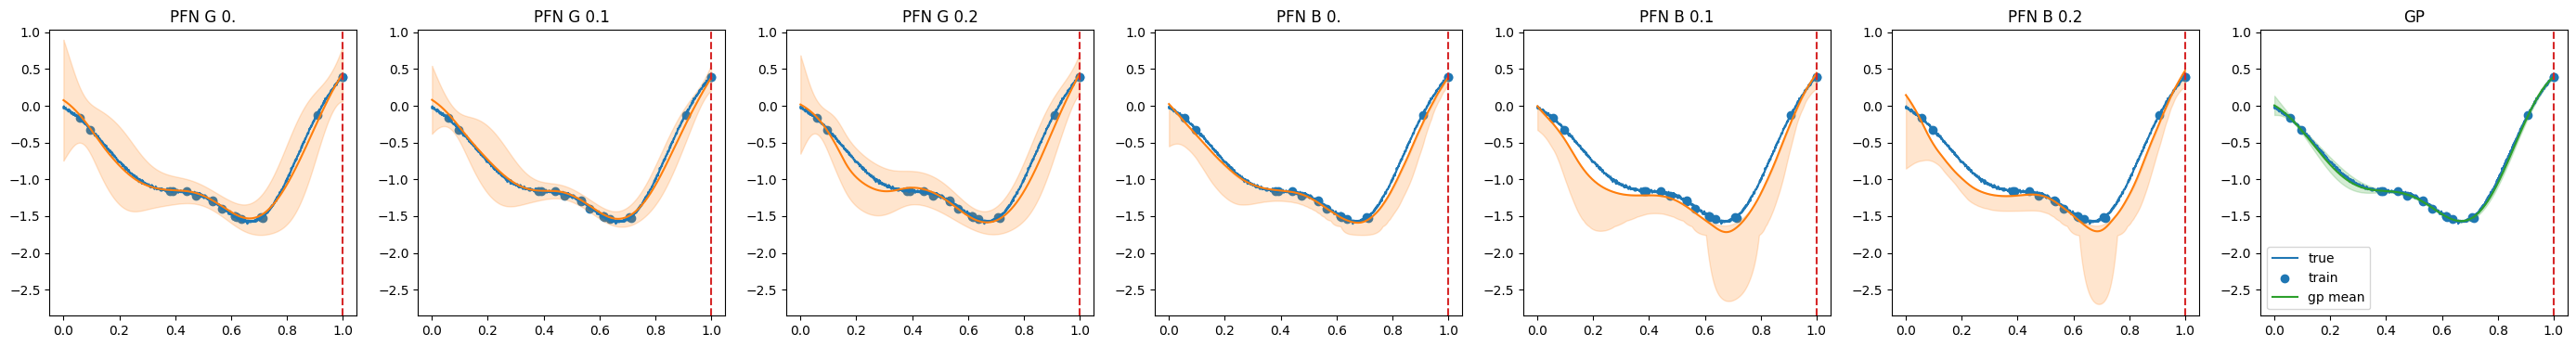

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


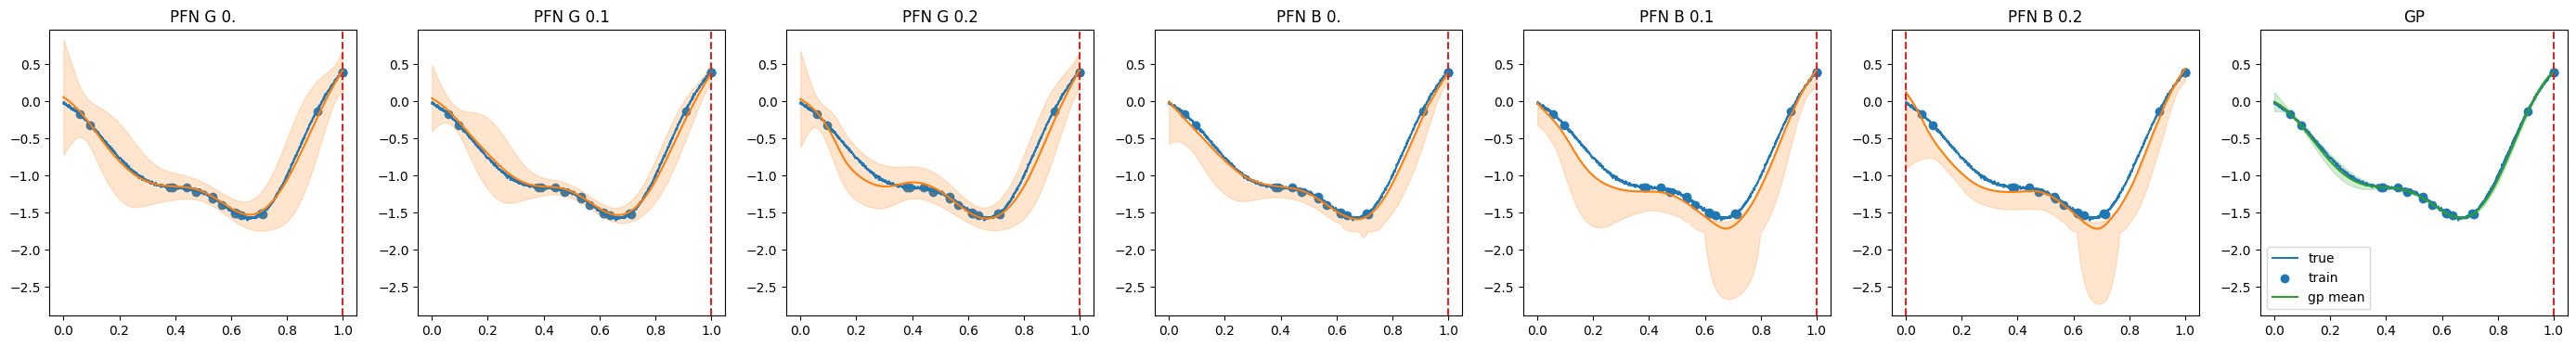

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


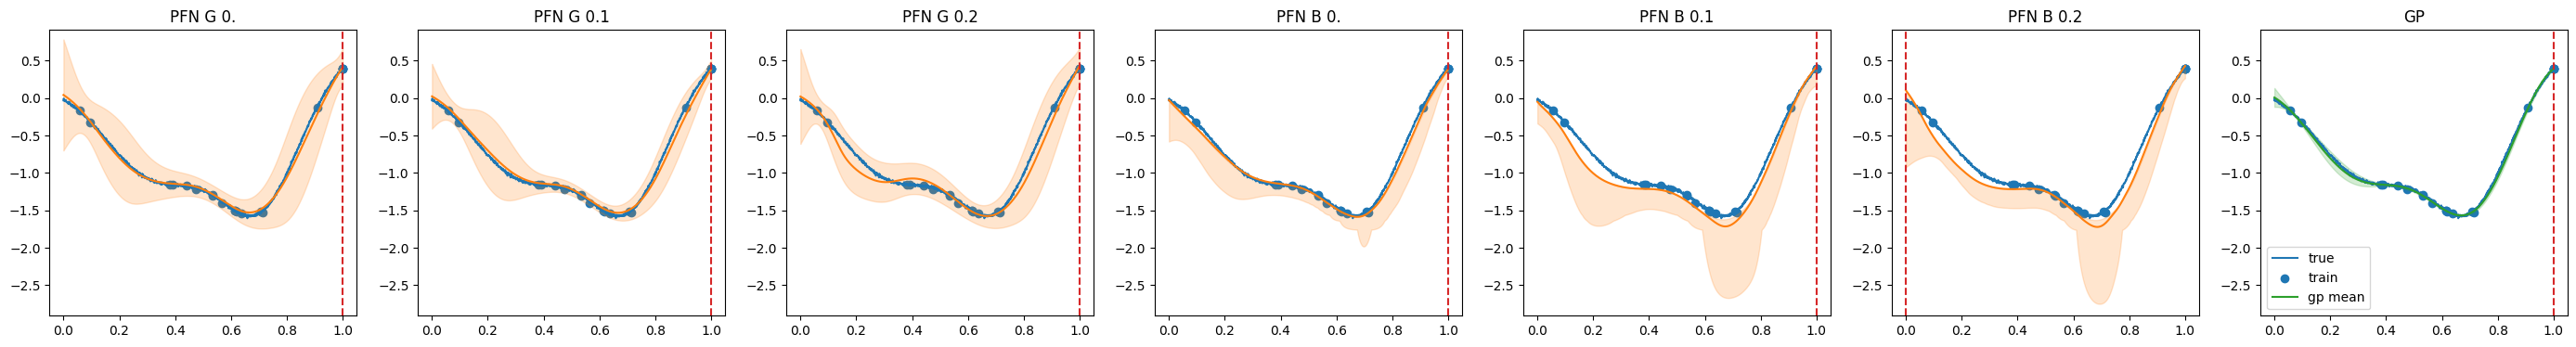

Seed 3
G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


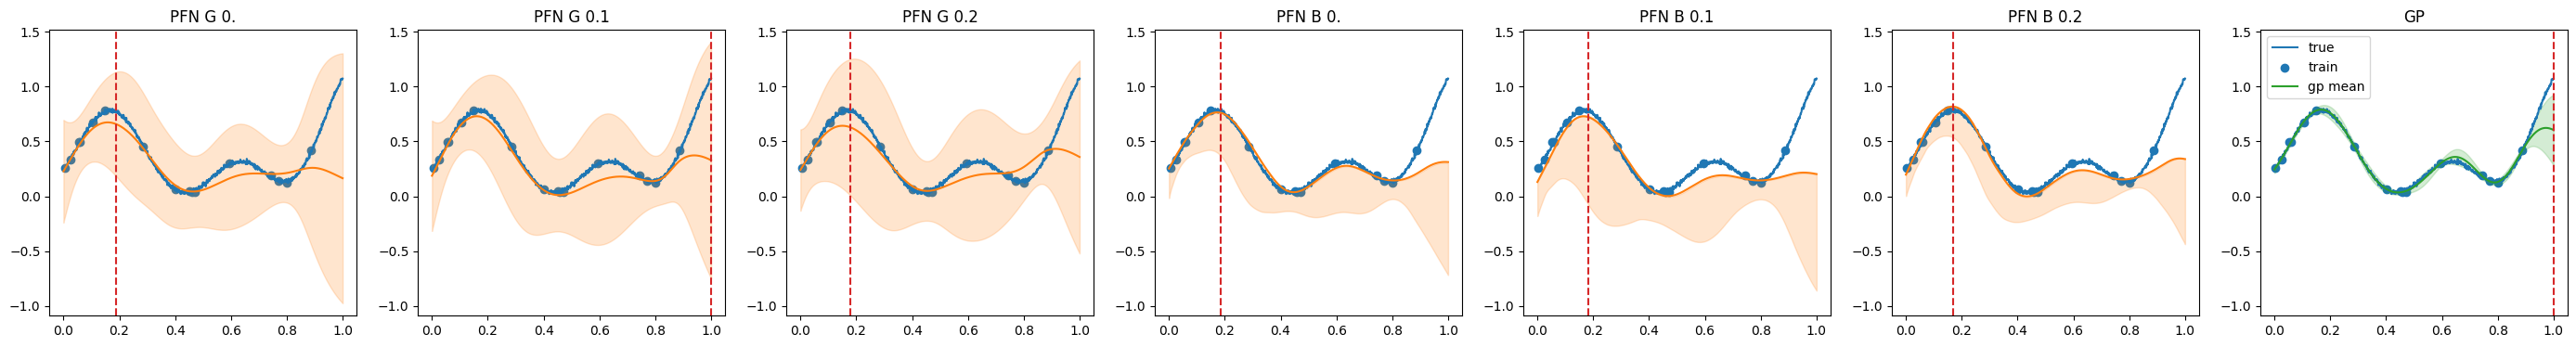

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


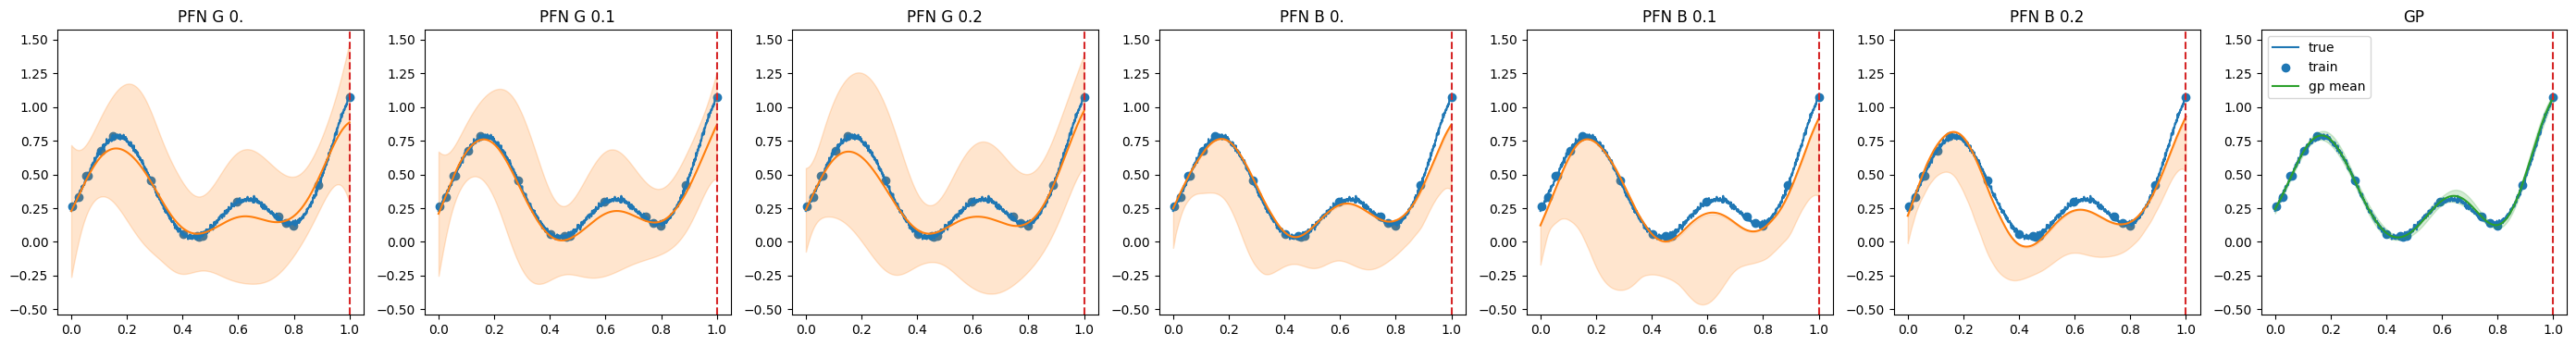

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


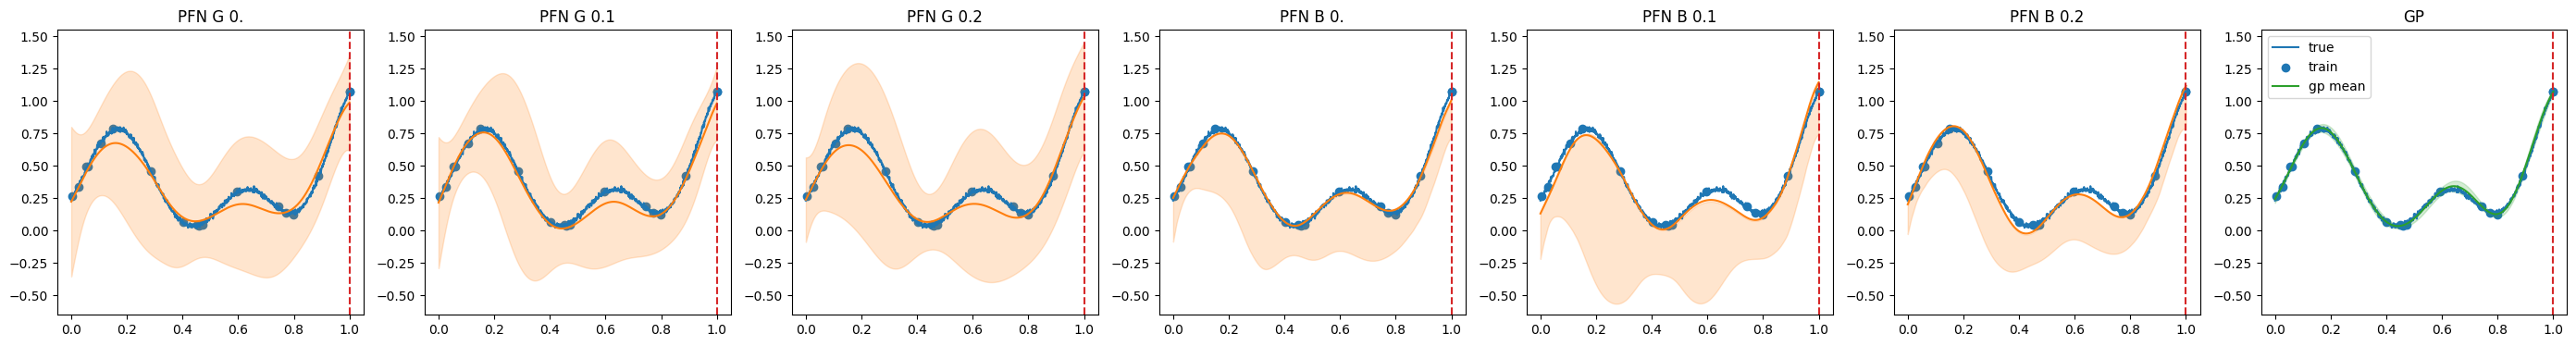

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


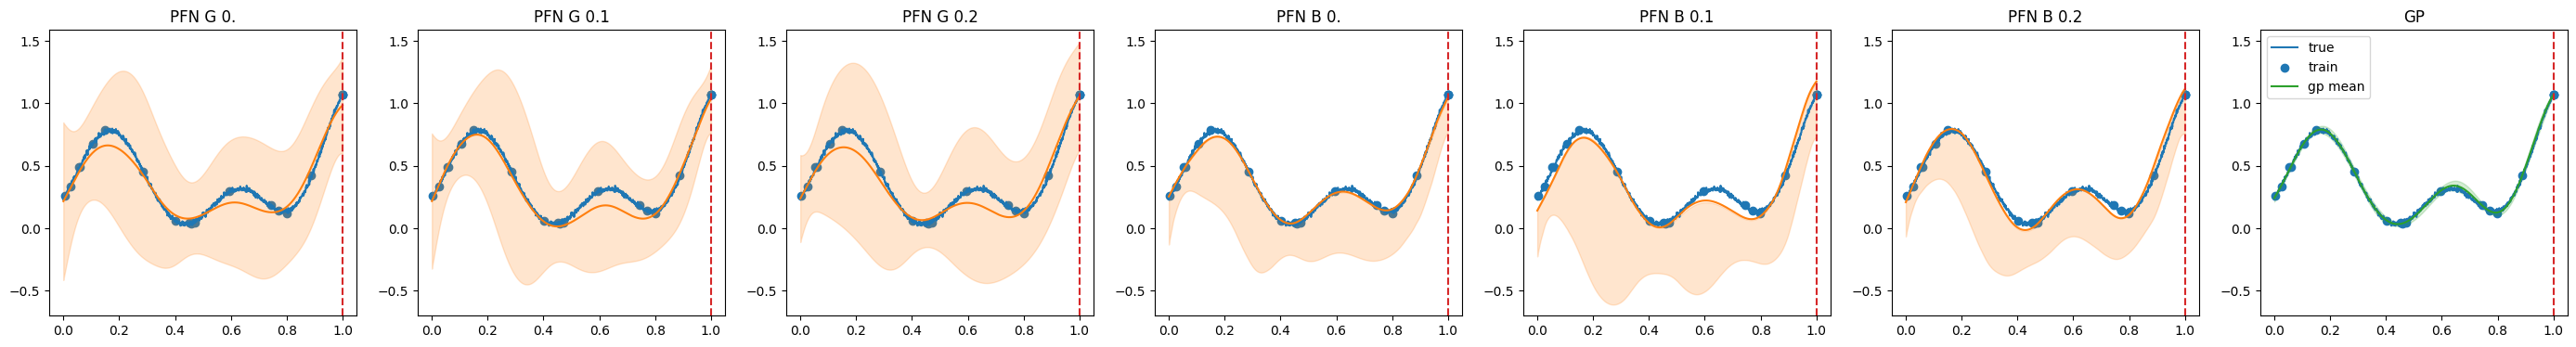

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


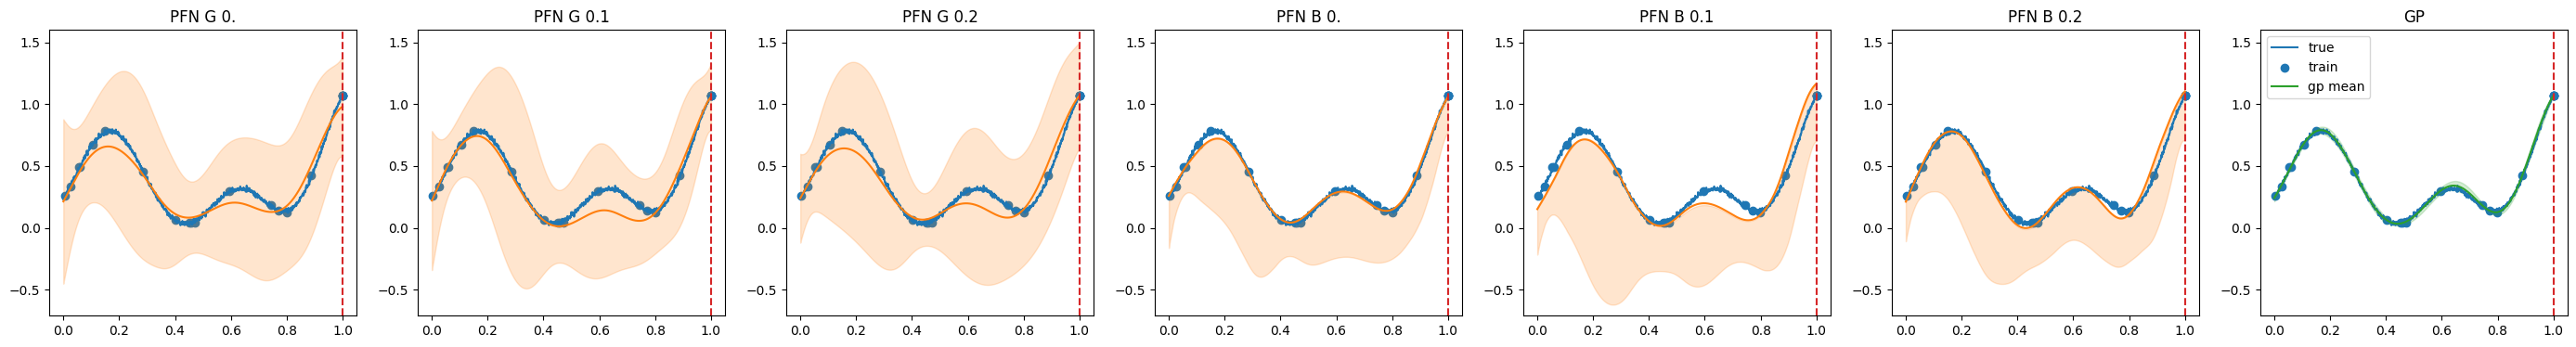

Seed 4
G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


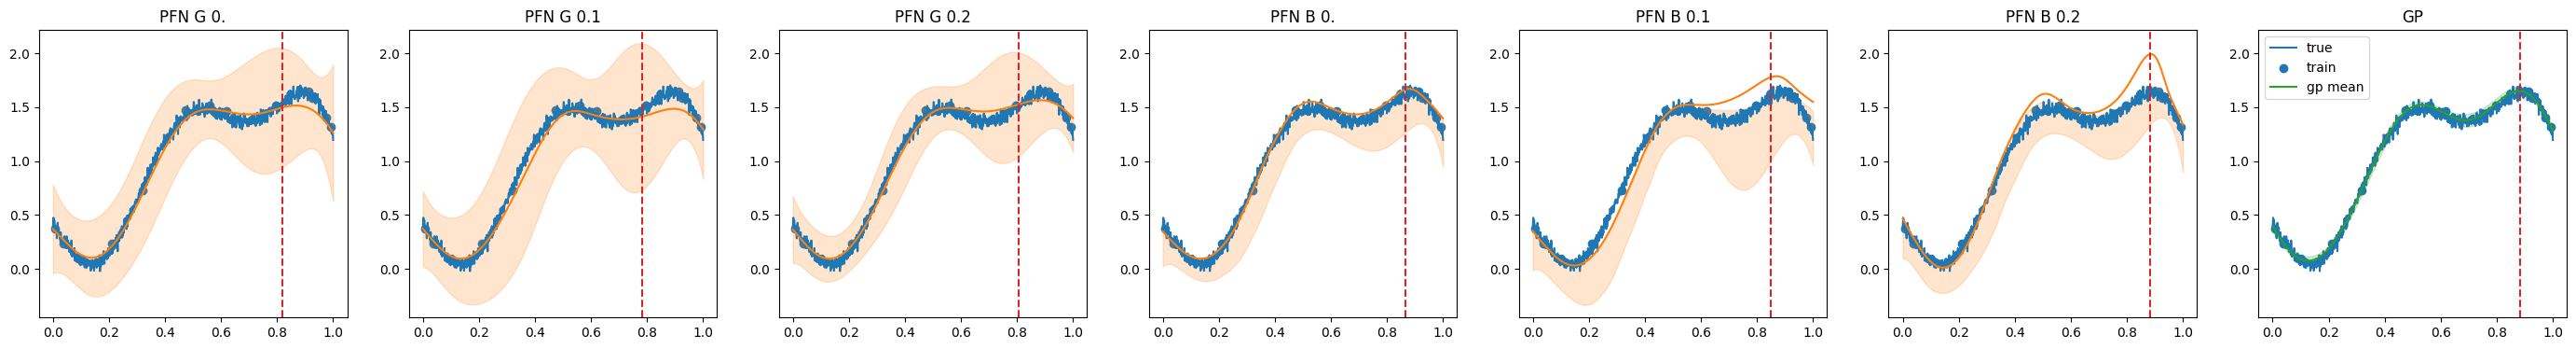

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


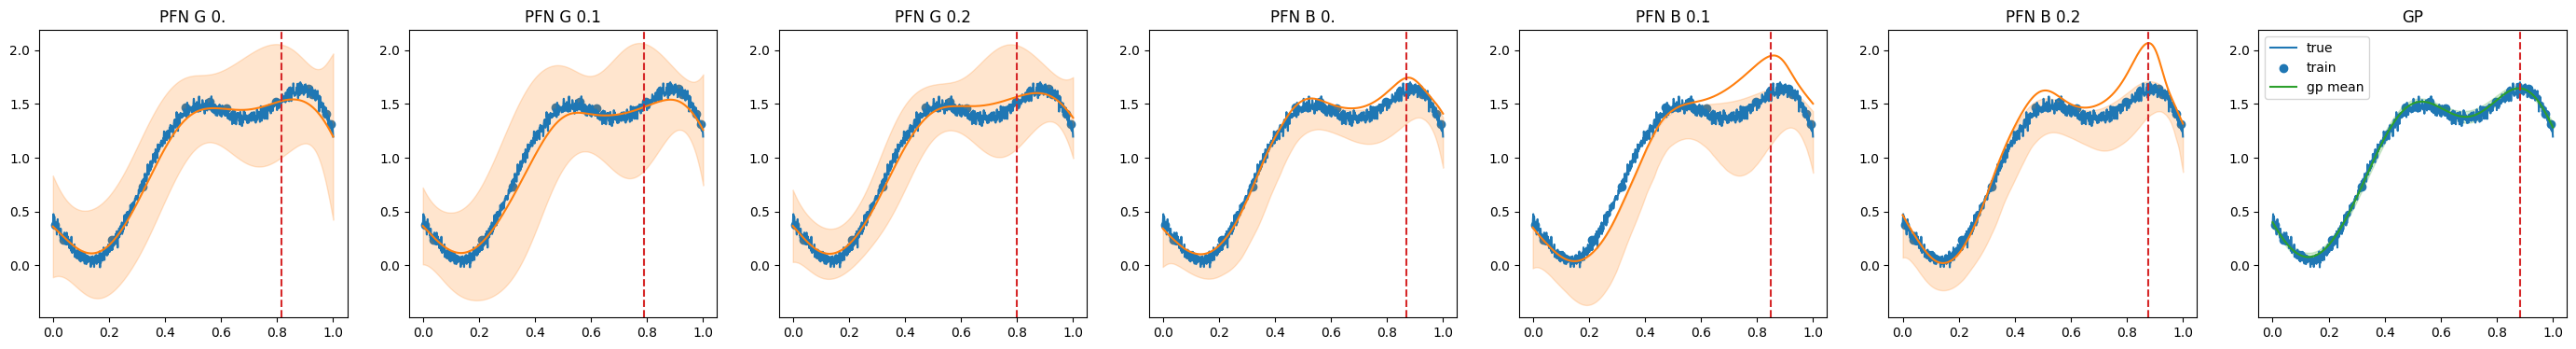

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


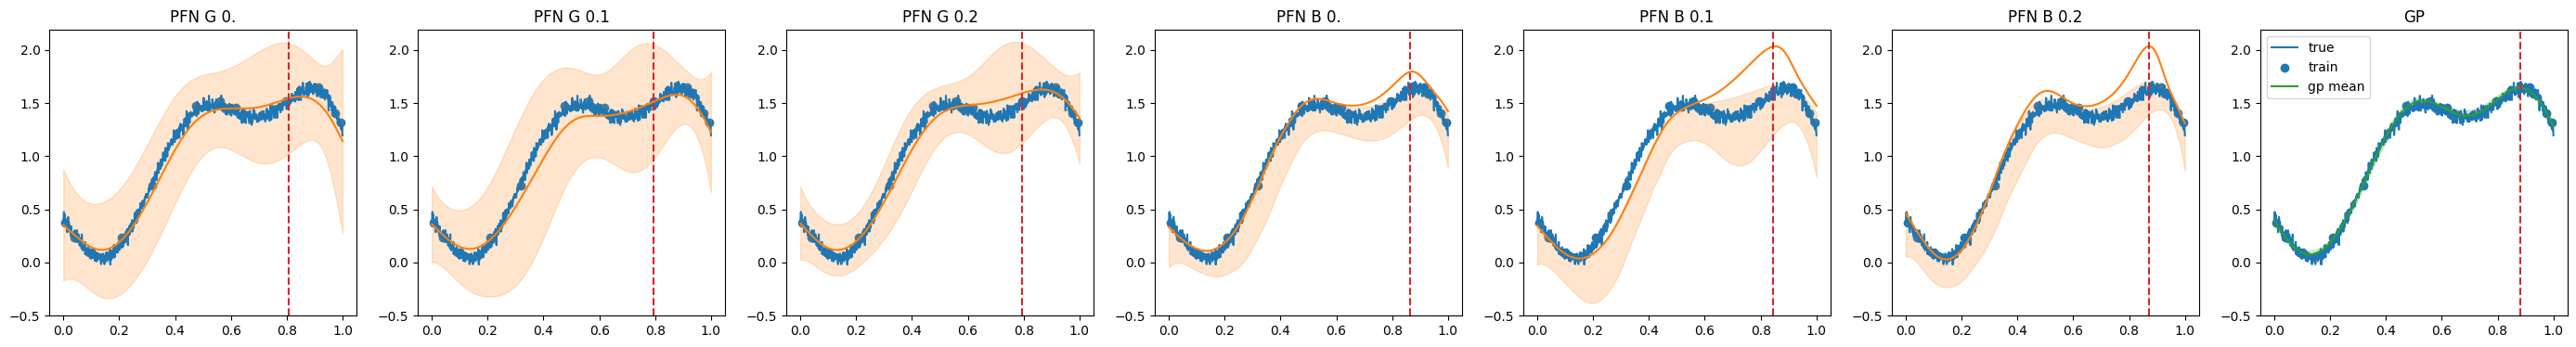

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


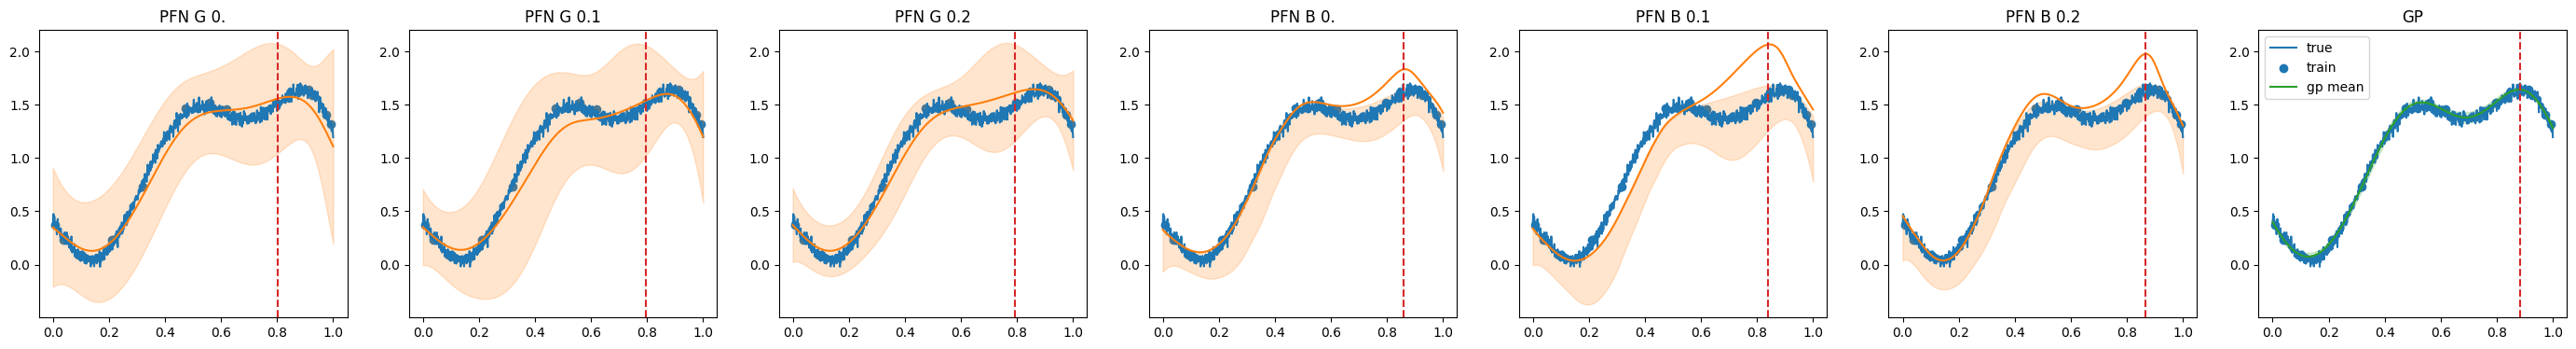

G 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
G 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.1
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])
B 0.2
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([1000, 1])


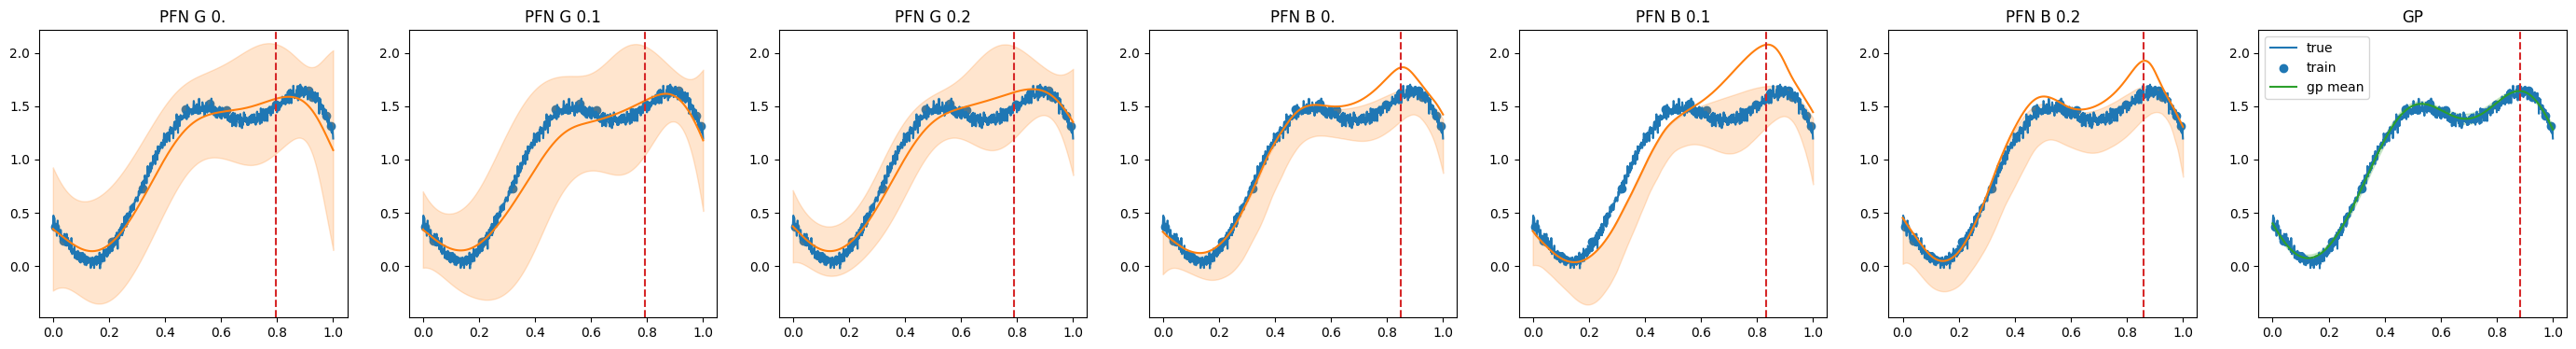

In [66]:
n_samples = 16
lengthscale = 0.2
for seed in range(5):
    print(f"Seed {seed}")
    test_info = get_test_function(n_samples, lengthscale, seed=seed)

    for _ in range(5):
        train_x, train_y, test_x, test_y = test_info
        queries = plot(test_info, pfn_infos)
        gp_next_x, gp_next_y = queries[-1]
        train_x = torch.cat([train_x, torch.tensor([[gp_next_x]])])
        train_y = torch.cat([train_y, torch.tensor([[gp_next_y]])])
        test_info = train_x, train_y, test_x, test_y